In [1]:
%autoreload 2
%load_ext autoreload

UsageError: Line magic function `%autoreload` not found.


In [2]:
import torch 
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd 
import seaborn as sns 

/var/cr01_data/sabri/miniconda3/envs/zoology/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# class Model1(nn.Module):
#     def __init__(
#         self, 
#         num_kv_pairs: int = 16,
#         d_model: int = 16,
#         freeze_embeddings: bool = True
#     ):
#         super().__init__()
#         self.embeddings = nn.Embedding(num_kv_pairs, d_model)
#         if freeze_embeddings:
#             self.embeddings.weight.requires_grad = False
#         self.layer = nn.Linear(d_model, d_model, bias=True)
    
#     def forward(self, x):
#         x = self.embeddings(x)
#         x = self.layer(x)
#         y = x @ self.embeddings.weight.T
#         return y, {}
    
class Model2(nn.Module):
    def __init__(
        self, 
        d_model: int = 16,
    ):
        super().__init__()
        self.layer1 = nn.Linear(2 * d_model, d_model, bias=True)
        self.layer2 = nn.Linear(d_model, d_model, bias=True)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        y = self.layer2(x)
        return y, {}
        
def learn_mapping(
    n: int = 32, # number of keys and values
    m: int = 4, # number of latent concepts
    k: int = 8, # number of edges 
    d_model: int = 16, 
    pbar: bool = False, 
    num_epochs: int = 3_000,
    log_interval: int = 200,
    device: int = 0, 
    model_cls: type = Model2,
    **kwargs
):

    keys_to_latent = torch.randint(0, m, (n,)).to(device)
    latent_to_values = torch.randint(0, n, (m, k)).to(device)

    embs = nn.init.normal_(torch.zeros(n, d_model)).to(device)
    edges = nn.init.normal_(torch.zeros(k, d_model)).to(device)

    y = embs[latent_to_values[keys_to_latent]].reshape(n * k, d_model).to(device)
    values = latent_to_values[keys_to_latent].reshape(n * k).to(device)

    x = torch.concat([
        embs[:, None, :].repeat(1, k, 1), 
        edges[None, :, :].repeat((n, 1, 1))
    ], dim=-1).reshape(n * k, 2 * d_model).to(device)
    # x = (
    #     embs[:, None, :] + edges[None, :, :]
    # ).reshape(n * k, d_model).to(device)

    model = model_cls(d_model=d_model, **kwargs)
    model.to(device)

    # Define a loss function and an optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    metrics = []
    for epoch in tqdm(range(num_epochs), disable=not pbar):  # 500 epochs
        optimizer.zero_grad()   # zero the gradient buffers
        output, meta = model(x)    # Forward pass

        output = output @ embs.T

        loss = criterion(output, values)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Does the update

        if epoch % log_interval == 0:
            metrics.append({
                'epoch': epoch,
                'loss': loss.item(),
                'accuracy': (output.argmax(dim=1) == values).float().mean().item()
            })
    return metrics[-1], metrics, meta, model

In [4]:
metrics, _, _, model = learn_mapping(
    n=32, 
    m=4,
    k=8,
    d_model=16, 
    pbar=True,   
    num_epochs=864,
    log_interval=200,
    device="cuda", 
    model_cls=Model2,   
)
metrics 

100%|██████████| 864/864 [00:00<00:00, 1037.78it/s]


{'epoch': 800, 'loss': 0.0448002927005291, 'accuracy': 1.0}

In [23]:
# num_kv_pairs_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
# num_kv_pairs_list = [131072]
n_list = [32, 64, 128, 512, 1024, 2048, 4096]

d_model_list = [16, 32, 64, 128, 256, 512]
# d_model_list = [16, 32, 64, 128]
results = []

for n in tqdm(n_list, desc='num_kv_pairs loop', position=0):
    for d_model in tqdm(d_model_list, desc='d_model loop', position=1, leave=False):
        metrics, _, _, _ = learn_mapping(
            n=n, 
            m=n // 8,
            k=8,
            d_model=d_model, 
            num_epochs=864,
            log_interval=200,
            device="cuda", 
            model_cls=Model2,
            pbar=False
        )
        results.append(
            {
                'n': n,
                'd_model': d_model,
                **metrics
            }
        )


num_kv_pairs loop: 100%|██████████| 7/7 [01:37<00:00, 13.89s/it]


<Axes: xlabel='d_model', ylabel='n'>

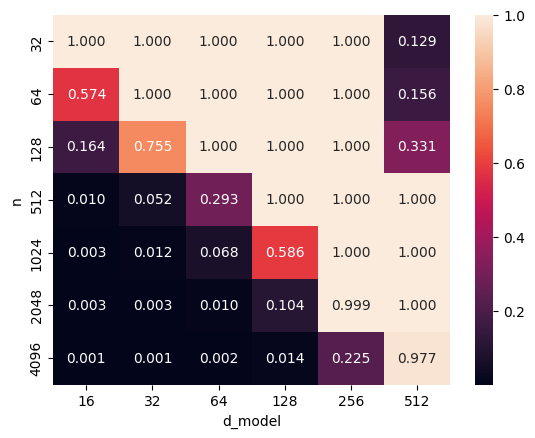

In [24]:
# Pivot the data
df = pd.DataFrame(results)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the size as needed

pivot_df = df.pivot(index='n', columns='d_model', values='accuracy')
    
# Create the heatmap
sns.heatmap(pivot_df, annot=True, fmt=".3f")


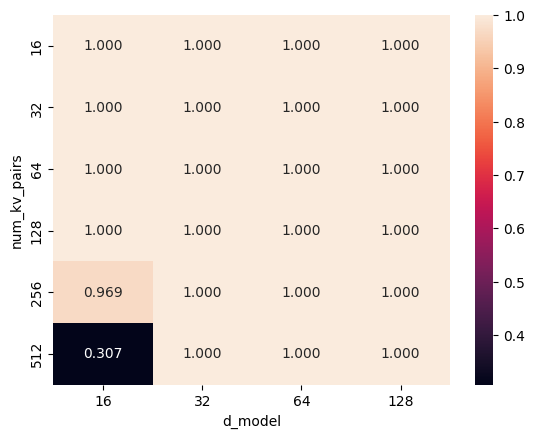

In [28]:
# Pivot the data
df = pd.DataFrame(results)
for moe in [False]:
    pivot_df = df[df["moe"]].pivot(index='num_kv_pairs', columns='d_model', values='accuracy')

    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".3f")


<Axes: xlabel='d_model', ylabel='num_kv_pairs'>

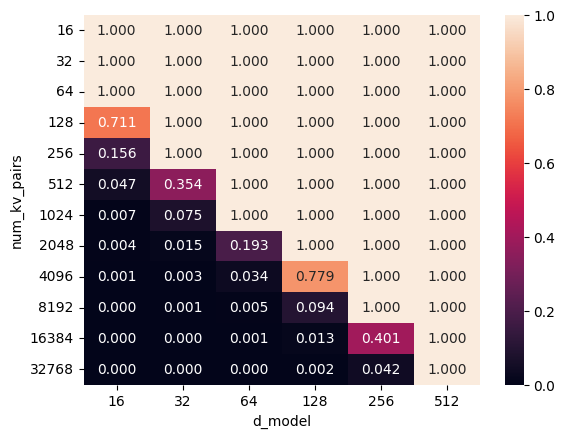

In [69]:
# Pivot the data
df = pd.DataFrame(results)
pivot_df = df.pivot(index='num_kv_pairs', columns='d_model', values='accuracy')

# Create the heatmap
sns.heatmap(pivot_df, annot=True, fmt=".3f")


In [70]:
((pivot_df > 0.98).values * pivot_df.index.values[:, None]).max(axis=0) / pivot_df.columns

Float64Index([4.0, 8.0, 16.0, 16.0, 32.0, 64.0], dtype='float64', name='d_model')

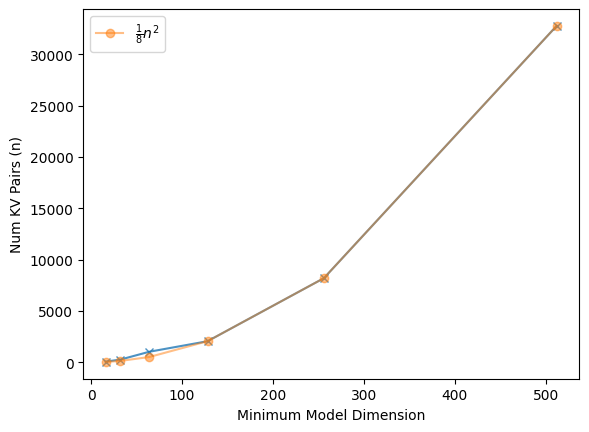

: 

In [78]:
import matplotlib.pyplot as plt
plt.plot(
    pivot_df.columns,
    ((pivot_df > 0.98).values * pivot_df.index.values[:, None]).max(axis=0), 
    marker='x',
    alpha=0.8
)
plt.plot(
    pivot_df.columns,
    (pivot_df.columns ** 2) / 8,
    marker='o',
    alpha=0.5,
    label=r"$\frac{1}{8} n^2$"
)
plt.xlabel("Minimum Model Dimension")
plt.ylabel("Num KV Pairs (n)")
plt.legend()

/Users/sabrieyuboglu/opt/miniconda3/envs/zoology/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


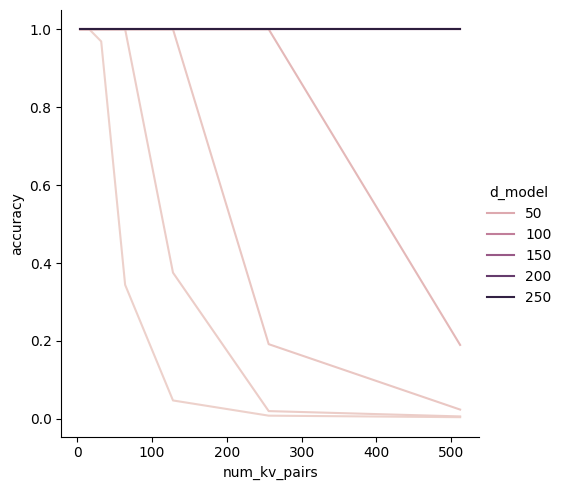

In [87]:
sns.relplot(
    data=df,
    x='num_kv_pairs',
    y='accuracy',
    hue='d_model',
    kind='line'
)

<Axes: >

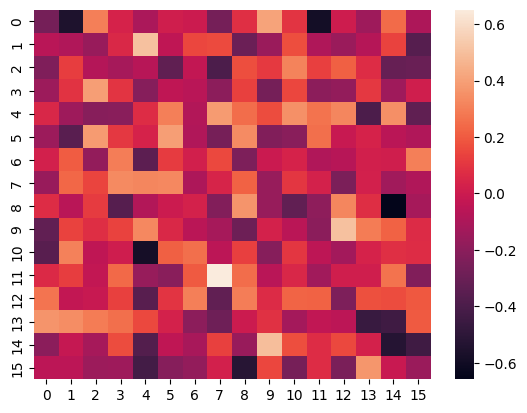

In [63]:

sns.heatmap(layer.layer.weight.detach().numpy())

In [55]:
df = pd.DataFrame(metrics)
df

,epoch,loss,accuracy
0,0,5.130624,0.0625
1,100,0.017283,1.0000
2,200,0.007714,1.0000
3,300,0.004847,1.0000
4,400,0.003494,1.0000
5,500,0.002713,1.0000
6,600,0.002208,1.0000
7,700,0.001856,1.0000
8,800,0.001597,1.0000
9,900,0.001399,1.0000


In [7]:
layer = nn.Linear(16, 16, bias=False)


SyntaxError: invalid syntax (1975303595.py, line 1)